## Mirror Langevin with Different Discretizations 

We draw samples uniformly from box (-0.01,0.01) x (-1,1) and test out Mirror Langevin with Euler-Maruyama, explicit (forward), implicit (backward) discretizations, in addition to projected Langevin.


In [1]:
# Specify potential and parameters

import numpy as np
import scipy.misc

# box constraint for potential
a = 0.01
b = 1.0

h = 1e-5  # step size
# smoothness parameter of log barrier (this is the potential we aim to sample from)
alpha = 1e-4  

iteration = 200  # length of each run

# for numerically inverting and prox solver
inner_iter = 50
stepsize = 5e-2

rep = 200  # number of trials to plot

num = 10   # number of EM interval (forward/backward)


Populating the interactive namespace from numpy and matplotlib


Text(0.5, 1.0, 'Uniform draws from box')

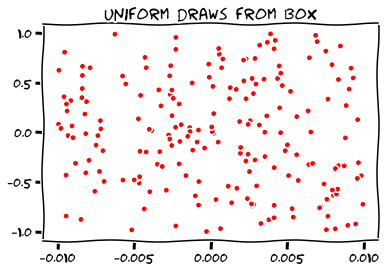

In [2]:

# Uniform draws from box
x_axis = np.random.uniform(-a,a,200)
y_axis = np.random.uniform(-b,b,200)

# plot samples
%pylab inline
plt.xkcd()
plt.plot(x_axis,y_axis,'r.')
plt.title('Uniform draws from box')


Mirror Langevin targets approximate distribution \\( \exp(-\beta\cdot\phi) \\) for \\( \phi=-\log(1-x_1^2)-\log(0.01^2-x_2^2) \\) and \\( \beta=10^{-4} \\). In the 3 discretization schemes that follow, we pick mirror map = barrier function.

Text(0.5, 1.0, 'Discretizing both objective and geometry (EM)')

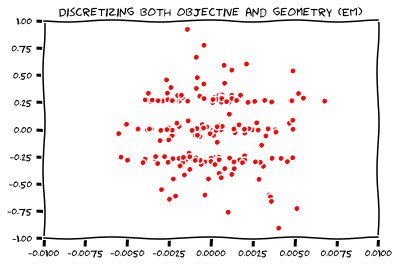

In [5]:
# EM discretization, target approximate distribution 

# suggest existence of irreducible bias

x_save = np.zeros((rep,2))

for j in range(rep):
    
    x = np.zeros((iteration+1,2))  # initialize

    for i in range(iteration):

        temp1 = b**2-x[i,0]**2
        temp2 = a**2-x[i,1]**2
        grad = np.array([2*x[i,0]/temp1, 2*x[i,1]/temp2])
        hess = np.array([[(2*temp1+4*x[i,0]**2)/temp1**2, 0], [0, (2*temp2+4*x[i,1]**2)/temp2**2]])
        z = np.random.normal(0,1,2)
        next_y = alpha*grad-h*alpha*grad+np.sqrt(2*h*alpha)*np.dot(scipy.linalg.sqrtm(hess),z)

        # numerically invert
        solver_x = x[i,:] # initialize
        for k in range(inner_iter):
            tmp1 = b**2-solver_x[0]**2
            tmp2 = a**2-solver_x[1]**2
            nabla_V_x = np.array([2*solver_x[0]/tmp1, 2*solver_x[1]/tmp2])
            # gradient ascent step for finding next x
            solver_x = solver_x + stepsize*(next_y - alpha*nabla_V_x)

        # check norm of gradient
        #print(np.linalg.norm(next_y-alpha*nabla_V_x))
        x[i+1,:] = solver_x
        
    x_save[j,:] = x[iteration,:]


plt.plot(x_save[:,0],x_save[:,1],'r.')
plt.ylim([-b,b])
plt.xlim([-a,a])
plt.title('Discretizing both objective and geometry (EM)')



Text(0.5, 1.0, 'Discretizing objective and not geometry (forward)')

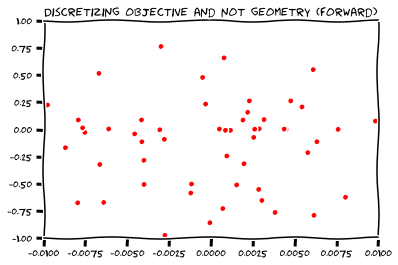

In [4]:
# Forward Discretization

x_save = np.zeros((rep,2))

for j in range(rep):
    
    x = np.zeros((iteration+1,2))  # initialize with (0,0)

    for i in range(iteration):

        temp1 = b**2-x[i,0]**2
        temp2 = a**2-x[i,1]**2
        grad = np.array([2*x[i,0]/temp1, 2*x[i,1]/temp2])
        next_y = alpha*grad-h*alpha*grad  # mirror descent step y_0
        
        for m in range(num):   # 10 steps of EM
            
            # initialize with last iterate
            if m == 0:
                solver_x = x[i,:] 
            
            # invert to next_y get next x for which we use to compute hessian
            for k in range(inner_iter):
                tmp1 = b**2-solver_x[0]**2
                tmp2 = a**2-solver_x[1]**2
                nabla_V_x = np.array([2*solver_x[0]/tmp1, 2*solver_x[1]/tmp2])
                # gradient ascent step for finding next x
                solver_x = solver_x + stepsize*(next_y- alpha*nabla_V_x)

            # diffusion part solved by $num$ steps of EM
            temp1 = b**2-solver_x[0]**2
            temp2 = a**2-solver_x[1]**2
            hess = np.array([[(2*temp1+4*solver_x[0]**2)/temp1**2, 0], 
                [0, (2*temp2+4*solver_x[1]**2)/temp2**2]])
            z = np.random.normal(0,1,2)
            next_y = next_y + np.sqrt(2*h*alpha/num)*np.dot(scipy.linalg.sqrtm(hess),z)  
        
        # invert one last time to get x_{k+1}
        for k in range(inner_iter):
            tmp1 = b**2-solver_x[0]**2
            tmp2 = a**2-solver_x[1]**2
            nabla_V_x = np.array([2*solver_x[0]/tmp1, 2*solver_x[1]/tmp2])
            # gradient ascent step 
            solver_x = solver_x + stepsize*(next_y- alpha*nabla_V_x)
        
        x[i+1,:] = solver_x
    
    x_save[j,:] = x[iteration,:]


plt.plot(x_save[:,0],x_save[:,1],'r.')
plt.ylim([-b,b])
plt.xlim([-a,a])
title('Discretizing objective and not geometry (forward)')



Text(0.5, 1.0, 'Discretizing objective and not geometry (backward)')

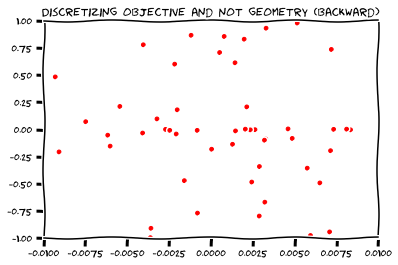

In [7]:
# Backward Discretization

x_save = np.zeros((rep,2))

for j in range(rep):
    
    x = np.zeros((iteration+1,2))  # initialize with (0,0)

    for i in range(iteration):
        
        for m in range(num):   # 10 steps of EM
            
            # initialize with last iterate
            if m == 0:
                solver_x = x[i,:]
                tmp1 = b**2-solver_x[0]**2
                tmp2 = a**2-solver_x[1]**2
                nabla_V_x = np.array([2*solver_x[0]/tmp1, 2*solver_x[1]/tmp2])
                next_y = alpha*nabla_V_x

            # diffusion part solved by $num$ steps of EM
            temp1 = b**2-solver_x[0]**2
            temp2 = a**2-solver_x[1]**2
            hess = np.array([[(2*temp1+4*solver_x[0]**2)/temp1**2, 0], 
                [0, (2*temp2+4*solver_x[1]**2)/temp2**2]])
            z = np.random.normal(0,1,2)
            next_y = next_y + np.sqrt(2*h*alpha/num)*np.dot(scipy.linalg.sqrtm(hess),z) 
            
            # invert next_y to get x for which we use to compute hessian
            for k in range(inner_iter):
                tmp1 = b**2-solver_x[0]**2
                tmp2 = a**2-solver_x[1]**2
                nabla_V_x = np.array([2*solver_x[0]/tmp1, 2*solver_x[1]/tmp2])
                # gradient ascent step for finding next x
                solver_x = solver_x + stepsize*(next_y- alpha*nabla_V_x)
        
        # prox step for next x (using next_y from diffusion part)
        for k in range(inner_iter):
            temp1 = b**2-solver_x[0]**2
            temp2 = a**2-solver_x[1]**2
            grad = np.array([2*solver_x[0]/temp1, 2*solver_x[1]/temp2])
            solver_x = solver_x - stepsize*(h*alpha*grad + alpha*grad - next_y)
        
        x[i+1,:] = solver_x
    
    x_save[j,:] = x[iteration,:]


plt.plot(x_save[:,0],x_save[:,1],'r.')
plt.ylim([-b,b])
plt.xlim([-a,a])
plt.title('Discretizing objective and not geometry (backward)')



Projected Langevin targets the constrained uniform distribution \\( [-0.01,0.01]\times[-1,1] \\) directly.

Text(0.5, 1.0, 'Projected Langevin')

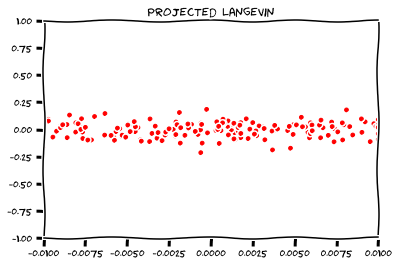

In [6]:
# Projected Langevin
# target uniform distribution directly (no bias but slow)

x_save = np.zeros((rep,2))

for j in range(rep):
    
    x = np.zeros((iteration+1,2))  # initialize

    for i in range(iteration):

        #temp1 = b^2-x(i,1)^2;
        #temp2 = a^2-x(i,2)^2;
        #grad = [2*x(i,1)/temp1; 2*x(i,2)/temp2];  # gradient for barrier
        grad = np.array([0,0])   # gradient for indicator
        z = np.random.normal(0,1,2)
        next_x = x[i,:]-h*alpha*grad+sqrt(2*h)*z
        x[i+1,:] = next_x

        # projection 
        if next_x[0] >= a:
            x[i+1,0] = a
        elif next_x[0] <= -a:
            x[i+1,0] = -a
        
        if next_x[1] >= b:
            x[i+1,1] = b
        elif next_x[1] <= -b:
            x[i+1,1] = -b
    
    x_save[j,:] = x[iteration,:]


plt.plot(x_save[:,0],x_save[:,1],'r.')
plt.ylim([-b,b])
plt.xlim([-a,a])
plt.title('Projected Langevin')
